In [160]:
import torch
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
from torchtext.datasets import AG_NEWS
from torch.utils import data
import matplotlib.pyplot as plt
# Get cpu, gpu or mps device for training.
device = (
    "cuda" 
    if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [161]:
class_names = "Undertermined,World,Sports,Business,Sci/Tech".split(',')
print(class_names)
for type, sent in AG_NEWS(split='train'):
    class_names[type]
    print(class_names[type], ' : ',sent)
    break

['Undertermined', 'World', 'Sports', 'Business', 'Sci/Tech']
Business  :  Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [162]:
# # pre-fetch
# path = 'data/new_excerpt.txt'
# with open(path,'w') as fp:
#     for type, sent in AG_NEWS(split='train'):
#         fp.write(sent+'\n')
path = 'data/new_excerpt.txt'
with open(path,'r') as fp:
    excerpt = fp.read()

In [163]:
# nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

def preprocess(excerpt:str):
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    excerpt = excerpt.lower()
    words = word_tokenize(sent)
    words = (lemmatizer.lemmatize(word) for word in words)
    words = filter(lambda word: word.isalpha(),words)
    words = filter(lambda word: word not in stop_words,words)
    # words = (word for word in words if word not in stop_words)
    return words
processed = preprocess(excerpt)

In [164]:
vocabs = set(processed)
word_to_int = {w:i+1 for i,w in enumerate(vocabs)}
word_to_int[0] = ''
vocab_size = len(word_to_int)
int_to_word = {i:w for w,i in word_to_int.items()}

In [165]:
for type,sent in AG_NEWS(split='train'):
    words = preprocess(sent)
    encoded = [word_to_int.get(w,0) for w in words]
    encoded = torch.tensor(encoded)
    print(encoded.shape)
    break

torch.Size([12])


In [166]:
def build_dataset(seq_len,n,split):
    X, ys = torch.zeros(n,seq_len,dtype=int),torch.zeros(n,dtype=int)
    for i,(type, sent) in zip(range(n),AG_NEWS(split=split)):
        n -= 1
        if n < 0: break
        
        words = preprocess(sent)
        encoded = [word_to_int.get(w,0) for w in words]
        x = torch.tensor(encoded)
        y = type
        if x.size(0) >= seq_len:
            x = x[:seq_len]
        else:
            pad_sz = seq_len - x.size(0)
            x = F.pad(x,(pad_sz,0),value=0)
        X[i] = x
        ys[i] = y
    return X,ys

def build_loader(seq_len,n,split,batch_size):
    X,y = build_dataset(seq_len,n,split)
    train_dataset = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size,drop_last=True)
    return train_dataset
train_dataset = build_loader(200,60000,'train',batch_size = 128)
test_dataset = build_loader(200,5000,'test',batch_size = 128)

In [167]:
for X,y in train_dataset:
    X = F.one_hot(X, vocab_size)
    print(X.shape,y.shape)
    print(X)
    print(y)
    break

torch.Size([128, 200, 11]) torch.Size([128])
tensor([[[1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 1, 0, 0]],

        [[1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 1, 0, 0]],

        [[1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 1, 0, 0]],

        ...,

        [[1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 1, 0, 0]],

        [[1, 0, 0,  ..., 0, 0, 0],
  

In [168]:
class RNN_New_Classifier(nn.Module):
    def __init__(self,embed_sz,hidden_sz,num_layers,vocab_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_sz = hidden_sz
        self.embedding = nn.Embedding(vocab_size,embed_sz)
        self.rnn = nn.LSTM(
            input_size = embed_sz,
            hidden_size = hidden_sz,
            num_layers = num_layers,
            batch_first = True,
            dropout = 0.5,
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_sz,len(class_names)),
            nn.LogSoftmax(1),
        )
        
    def forward(self, x, h=None):
        # x (batch_sz,seq_len)
        x = self.embedding(x)
        # rnn(batch_sz,seq_len,input_sz)
        # -> x - (batch_sz,seq_len,hidden_sz),
        #    h - (n_layers,batch_sz,hidden_sz)
        x,h = self.rnn(x,h)
        # (batch_sz,hidden_sz)
        x = x[:,-1] # get the last
        x = x.reshape(-1,self.hidden_sz)
        x = self.fc(x)
        return x,h
    
    def init_hidden(self,batch_size):
        num_layers = self.rnn.num_layers
        hidden_sz = self.rnn.hidden_size
        return (torch.zeros(num_layers,batch_size,hidden_sz),
                torch.zeros(num_layers,batch_size,hidden_sz))

loss_fn = nn.CrossEntropyLoss()
model = RNN_New_Classifier(30,512,2,vocab_size)


for X,y in train_dataset:
    h = model.init_hidden(train_dataset.batch_size)
    print("--in--")
    print(X.shape,y.shape)
    print("--intermediate--")
    out,h = model(X)
    print("--out--")
    print(out.shape,[each.shape for each in h])
    probs = out.exp()
    probs = probs.sum(1)
    assert(torch.isclose(torch.ones_like(probs),probs).all().item())
    print(loss_fn(out,y))
    break

--in--
torch.Size([128, 200]) torch.Size([128])
--intermediate--
--out--
torch.Size([128, 5]) [torch.Size([2, 128, 512]), torch.Size([2, 128, 512])]
tensor(1.6031, grad_fn=<NllLossBackward0>)


In [169]:
def plot_hist(i,train_losses,test_losses):
    clear_output()
    plt.title(f'step = {i}')
    plt.plot(train_losses,label='train')
    plt.plot(test_losses,label='test')
    plt.legend()
    plt.show()

In [170]:
def train(model,loader:data.DataLoader,test_batch,optimizer):
    from itertools import cycle
    test_batch = cycle(test_batch)
    h = model.init_hidden(loader.batch_size)
    train_hist,test_hist = [],[]
    steps = 0
    for X,y in loader:
        steps += 1
        model.train()
        X = X.to(device)
        y = y.to(device)
        
        # backprop through time
        h = tuple([each.data.to(device) for each in h])
        
        # forward pass
        pred,h = model(X,h)
        loss = loss_fn(pred,y)
        
        # clip
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_hist.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            X,y = next(test_batch)
            X = X.to(device)
            y = y.to(device)
            pred,_ = model(X)
            loss = loss_fn(pred,y)
            test_hist.append(loss.item())
        
        if steps % 50 == 0:
            plot_hist(steps,train_hist,test_hist)
    
    return train_hist,test_hist

In [171]:
model = RNN_New_Classifier(500,512,2,vocab_size).to(device)

In [172]:
train_losses = []
test_losses = []

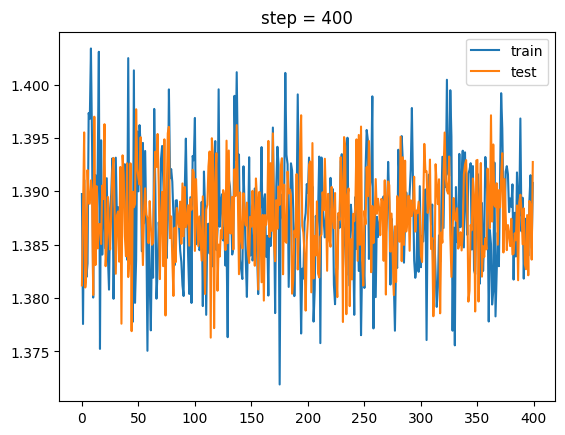

In [173]:
from IPython.display import clear_output
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
epochs = 2
# train_hist_loss = []

for i in range(epochs):
    train_hist, test_hist = train(model,train_dataset,iter(test_dataset),optimizer)
    
    train_losses.extend(train_hist)
    test_losses.extend(test_hist)

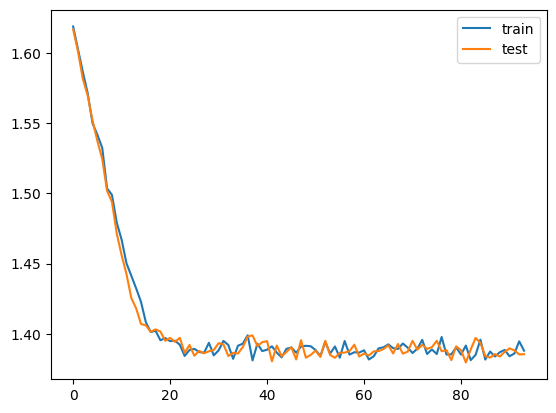

In [174]:
k = 10
plt.plot(train_losses[::k],label='train')
plt.plot(test_losses[::k],label='test')
plt.legend()
plt.show()

In [175]:
with torch.no_grad():
    correct_count = 0
    sz = 0
    for X,y in train_dataset:
        X = X.to(device)
        y = y.to(device)
        probs,_ = model(X)
        pred = probs.argmax(1)
        # print(pred[:10])
        # print(yte[:10])
        correct_count += (y==pred).sum()
        sz += y.size(0)
    print(correct_count/sz)

tensor(0.2586, device='cuda:0')


In [176]:
with torch.no_grad():
    correct_count = 0
    sz = 0
    for X,y in test_dataset:
        X = X.to(device)
        y = y.to(device)
        probs,_ = model(X)
        pred = probs.argmax(1)
        # print(pred[:10])
        # print(yte[:10])
        correct_count += (y==pred).sum()
        sz += y.size(0)
    print(correct_count/sz)

tensor(0.2572, device='cuda:0')
